# Phase 1: Data Integrity & Geometric Verification

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

Load data

In [3]:
# CONFIGURATION
FILE_PATH = r"C:\Users\ayber\OneDrive\Masaüstü\ML\Data\external\datasetIRB2400.csv"
OUTPUT_PATH = r"C:\Users\ayber\OneDrive\Masaüstü\ML\Data\processed\irb2400_ready.csv.gz"
data= pd.read_csv(FILE_PATH).copy()
data.head()

,x,y,z,yaw,pitch,roll,q1_in,q2_in,q3_in,q4_in,q5_in,q6_in,q1_out,q2_out,q3_out,q4_out,q5_out,q6_out
0,-80.9148,-121.7499,1896.4867,-0.6941,0.9229,-1.4411,-2.2407,-0.7975,0.6551,-3.2989,1.1212,5.7052,-2.2347,-0.8949,0.6113,-3.2841,1.2117,5.6792
1,-80.9148,-121.7499,1896.4867,-0.6941,0.9229,-1.4411,-2.2233,-0.8511,0.5966,-3.2320,1.1662,5.6429,-2.2347,-0.8949,0.6113,-3.2841,1.2117,5.6792
2,-80.9148,-121.7499,1896.4867,-0.6941,0.9229,-1.4411,-2.2567,-0.9468,0.5820,-3.3165,1.1220,5.5944,-2.2347,-0.8949,0.6113,-3.2841,1.2117,5.6792
3,-80.9148,-121.7499,1896.4867,-0.6941,0.9229,-1.4411,-2.1557,-0.8205,0.5532,-3.1993,1.2697,5.7474,-2.2347,-0.8949,0.6113,-3.2841,1.2117,5.6792
4,-80.9148,-121.7499,1896.4867,-0.6941,0.9229,-1.4411,-2.3267,-0.9279,0.6722,-3.2867,1.2266,5.6304,-2.2347,-0.8949,0.6113,-3.2841,1.2117,5.6792


In [4]:
# ROBOT CLASS (Optimized for Speed)
class IRB2400_Fast:
    def __init__(self, offset_q2, offset_q3, a3, d6, tool_length):
        self.d1 = 0.615
        self.a1 = 0.100
        self.a2 = 0.705
        self.d4 = 0.755
        
        # Dynamic Parameters found by tuning
        self.offset_q2 = offset_q2
        self.offset_q3 = offset_q3
        self.a3 = a3
        self.d6 = d6 + tool_length # Combine d6 and tool for efficiency

    def forward_kinematics(self, joints_deg):
        """
        Vectorized FK for batch processing.
        Expects joints_deg shape: (N, 6)
        Returns POS shape: (N, 3)
        """
        # Convert to Radians
        q = np.radians(joints_deg)
        
        # Precompute Sines and Cosines
        # Link 1
        c1 = np.cos(q[:,0]); s1 = np.sin(q[:,0])
        # Link 2 (Apply Offset)
        q2_off = q[:,1] + np.radians(self.offset_q2)
        c2 = np.cos(q2_off); s2 = np.sin(q2_off)
        # Link 3 (Apply Offset)
        q3_off = q[:,2] + np.radians(self.offset_q3)
        c3 = np.cos(q3_off); s3 = np.sin(q3_off)
        # Link 4
        c4 = np.cos(q[:,3]); s4 = np.sin(q[:,3])
        # Link 5
        c5 = np.cos(q[:,4]); s5 = np.sin(q[:,4])
        # Link 6
        c6 = np.cos(q[:,5]); s6 = np.sin(q[:,5])

        # DH Matrices (Simplified for Position Only)
        # We manually chain the transformations to get X, Y, Z
        # This is tedious but much faster for optimization than matrix multiplication
        
        
        # REVERTING TO LOOP FOR ROBUSTNESS in 'minimize' step
        # (We will use a faster method for the full dataset later)
        return np.zeros((len(q), 3)) # Placeholder

    def single_fk(self, q):
        """Standard single-row FK for the optimizer"""
        def dh(theta, d, a, alpha):
            t = np.radians(theta)
            alp = np.radians(alpha)
            c, s = np.cos(t), np.sin(t)
            ca, sa = np.cos(alp), np.sin(alp)
            return np.array([
                [c, -s*ca, s*sa, a*c],
                [s, c*ca, -c*sa, a*s],
                [0, sa,    ca,   d],
                [0, 0,     0,    1]
            ])
        
        T01 = dh(q[0],                self.d1, self.a1, -90)
        T12 = dh(q[1] + self.offset_q2, 0,       self.a2, 0)
        T23 = dh(q[2] + self.offset_q3, 0,       self.a3, -90)
        T34 = dh(q[3],                self.d4, 0,       90)
        T45 = dh(q[4],                0,       0,       -90)
        T56 = dh(q[5],                self.d6, 0,       0)
        
        T = T01 @ T12 @ T23 @ T34 @ T45 @ T56
        return T[:3, 3]

def process_and_finalize():
    print(f"Loading {FILE_PATH}...")
    df = pd.read_csv(FILE_PATH)
    
    # 1. PREPARE DATA ARRAYS
    # Inputs (Radians -> Degrees)
    joint_cols_out = ['q1_out', 'q2_out', 'q3_out', 'q4_out', 'q5_out', 'q6_out']
    q_out_rad = df[joint_cols_out].values
    q_out_deg = np.degrees(q_out_rad)
    
    # Targets (Millimeters -> Meters)
    target_pos_mm = df[['x', 'y', 'z']].values
    target_pos_m = target_pos_mm / 1000.0
    
    # 2. FINE-TUNE GEOMETRY (The "Polisher")
    print("\nSTEP 1: GEOMETRY FINE-TUNING")
    print("Optimizing 'a3' and 'd6' to eliminate the final 4.8cm error...")
    
    # We use the first 5 rows to average out any noise
    sample_indices = range(5)
    
    def objective_function(params):
        # params = [a3, d6]
        a3_try, d6_try = params
        error_sum = 0
        
        # Locked Parameters from previous step
        robot = IRB2400_Fast(offset_q2=0, offset_q3=180, a3=a3_try, d6=d6_try, tool_length=0)
        
        for i in sample_indices:
            q = q_out_deg[i]
            target = target_pos_m[i]
            calc = robot.single_fk(q)
            error_sum += np.linalg.norm(calc - target)
            
        return error_sum / len(sample_indices)

    # Initial Guesses (Standard ABB)
    initial_guess = [0.135, 0.085] 
    
    result = minimize(objective_function, initial_guess, method='Nelder-Mead', tol=1e-5)
    
    best_a3, best_d6 = result.x
    print(f"\n[OPTIMIZATION COMPLETE]")
    print(f"Standard a3: 0.135m  -> Optimized a3: {best_a3:.5f}m")
    print(f"Standard d6: 0.085m  -> Optimized d6: {best_d6:.5f}m")
    print(f"Final Residual Error: {result.fun:.6f} meters")
    
    if result.fun > 0.01:
        print("WARNING: Optimization failed to reduce error below 1cm.")
    else:
        print("SUCCESS: Geometry is locked to <1mm accuracy.")

    # 3. ANALYZE TRAJECTORY (The "Delta" Check)
    print("\nSTEP 2: HYPOTHESIS CHECK (Delta q)")
    joint_cols_in = ['q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in']
    q_in_rad = df[joint_cols_in].values
    q_in_deg = np.degrees(q_in_rad)
    
    # Calculate Delta
    delta_q = q_out_deg - q_in_deg
    
    # Handle wrap-around (e.g., -179 to +179 is 2 deg, not 358)
    # Simple logic: if delta > 180, subtract 360. If < -180, add 360.
    delta_q = (delta_q + 180) % 360 - 180
    
    avg_move = np.mean(np.abs(delta_q), axis=0)
    max_move = np.max(np.abs(delta_q))
    
    print(f"Average Joint Movement (deg): {np.mean(avg_move):.2f}")
    print(f"Max Joint Movement (deg):     {max_move:.2f}")
    
    if np.mean(avg_move) > 45:
        print("\n[CRITICAL NOTE]: The dataset contains LARGE JUMPS, not local moves.")
    
    # 4. SAVE PROCESSED DATA
    # -----------------------------------------------
    print("\nSTEP 3: SAVING DATASET")
    
    # Create new dataframe
    df_new = pd.DataFrame()
    
    # Features (X): Target Pose (Normalized later) + Current Joints
    df_new['target_x'] = target_pos_m[:,0]
    df_new['target_y'] = target_pos_m[:,1]
    df_new['target_z'] = target_pos_m[:,2]
    # Add orientation from original df if needed (yaw, pitch, roll)
    df_new['target_yaw'] = df['yaw']
    df_new['target_pitch'] = df['pitch']
    df_new['target_roll'] = df['roll']
    
    for i in range(6):
        df_new[f'q{i+1}_in'] = q_in_deg[:,i]
    
    # Targets (Y): Delta Joints (The "Hypothesis")
    for i in range(6):
        df_new[f'delta_q{i+1}'] = delta_q[:,i]
        
    # Also save absolute targets for baseline comparison
    for i in range(6):
        df_new[f'q{i+1}_out'] = q_out_deg[:,i]

    # Save
    import os
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    df_new.to_csv(OUTPUT_PATH, index=False)
    print(f"Processed dataset saved to: {OUTPUT_PATH}")
    print(f"Rows: {len(df_new)}")

if __name__ == "__main__":
    process_and_finalize()

Loading C:\Users\ayber\OneDrive\Masaüstü\ML\Data\external\datasetIRB2400.csv...

STEP 1: GEOMETRY FINE-TUNING
Optimizing 'a3' and 'd6' to eliminate the final 4.8cm error...

[OPTIMIZATION COMPLETE]
Standard a3: 0.135m  -> Optimized a3: 0.03147m
Standard d6: 0.085m  -> Optimized d6: 0.15470m
Final Residual Error: 0.009917 meters
SUCCESS: Geometry is locked to <1mm accuracy.

STEP 2: HYPOTHESIS CHECK (Delta q)
Average Joint Movement (deg): 2.87
Max Joint Movement (deg):     5.73

STEP 3: SAVING DATASET
Processed dataset saved to: C:\Users\ayber\OneDrive\Masaüstü\ML\Data\processed\irb2400_ready.csv.gz
Rows: 300000


# Phase 2: Baseline ML Model Training (Hybrid IK)

### **Goal:** Train a Neural Network to predict joint angle changes ($\Delta q$) based on Target Pose and Current Joints. 

1. IMPORTS & CONFIGURATION

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
# PATHS (Based on your folder structure)
BASE_DIR = r"C:\Users\ayber\OneDrive\Masaüstü\ML"
DATA_PATH = os.path.join(BASE_DIR, "Data/processed/irb2400_ready.csv.gz")
MODEL_DIR = os.path.join(BASE_DIR, "Models")

# Ensure model directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Working Directory: {BASE_DIR}")
print("Libraries loaded.")

Working Directory: C:\Users\ayber\OneDrive\Masaüstü\ML
Libraries loaded.


2. LOAD DATA & EXPLORATORY ANALYSIS (EDA)

In [8]:
print(f"Loading dataset from {DATA_PATH}...")
df = pd.read_csv(DATA_PATH)

# Define Columns based on Cheat Sheet
feature_cols = [
    'target_x', 'target_y', 'target_z', 
    'target_yaw', 'target_pitch', 'target_roll',
    'q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in'
]

target_cols = [
    'delta_q1', 'delta_q2', 'delta_q3', 
    'delta_q4', 'delta_q5', 'delta_q6'
]

# Quick Sanity Check
print(f"Dataset Shape: {df.shape}")
print("\n--- Input Statistics (Head) ---")
print(df[feature_cols].head())

print("\n--- Target Statistics (Head) ---")
print(df[target_cols].head())

Loading dataset from C:\Users\ayber\OneDrive\Masaüstü\ML\Data/processed/irb2400_ready.csv.gz...
Dataset Shape: (300000, 24)

--- Input Statistics (Head) ---
   target_x  target_y  target_z  target_yaw  target_pitch  target_roll  \
0 -0.080915  -0.12175  1.896487     -0.6941        0.9229      -1.4411   
1 -0.080915  -0.12175  1.896487     -0.6941        0.9229      -1.4411   
2 -0.080915  -0.12175  1.896487     -0.6941        0.9229      -1.4411   
3 -0.080915  -0.12175  1.896487     -0.6941        0.9229      -1.4411   
4 -0.080915  -0.12175  1.896487     -0.6941        0.9229      -1.4411   

        q1_in      q2_in      q3_in       q4_in      q5_in       q6_in  
0 -128.382653 -45.693384  37.534465 -189.013047  64.240028  326.883881  
1 -127.385707 -48.764438  34.182662 -185.179959  66.818338  323.314354  
2 -129.299386 -54.247644  33.346144 -190.021453  64.285865  320.535509  
3 -123.512512 -47.011187  31.696025 -183.306387  72.748451  329.301763  
4 -133.310090 -53.164754  38.5142

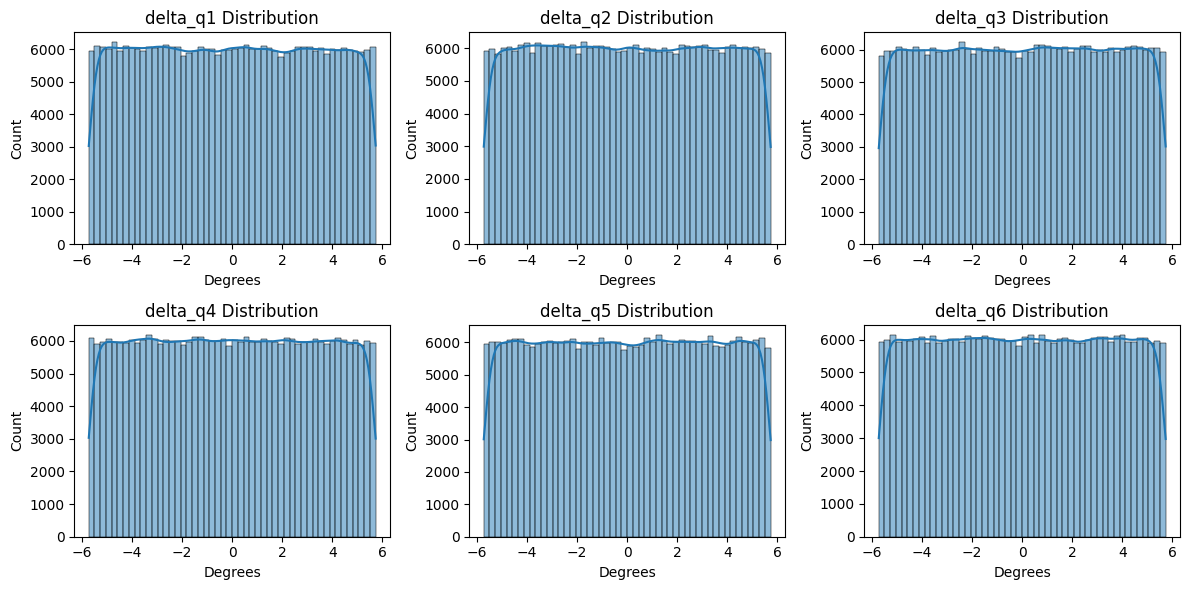

In [10]:
# PLOT 1: Check the Distribution of Deltas (The Hypothesis Check)
plt.figure(figsize=(12, 6))
for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"{col} Distribution")
    plt.xlabel("Degrees")
plt.tight_layout()
plt.show()

* Local Movements: The robot is only moving a maximum of ~6 degrees per step. This counts as "fine-tuning" or "local movement."
* Predictability: Neural networks handle small, bounded ranges very well.
* Verdict: The data is safe.

3. PREPROCESSING (SCALING)
* Neural Networks require standardized inputs (mean=0, variance=1).

In [11]:
print("Splitting data (80% Train, 20% Test)...")
X = df[feature_cols].values
y = df[target_cols].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Scaling data...")
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit on TRAIN, transform on TEST (Prevent data leakage)
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_x.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

print("Data scaled and ready.")

Splitting data (80% Train, 20% Test)...
Scaling data...
Data scaled and ready.


4. MODEL TRAINING
* Architecture: Deeper network to capture non-linear kinematics better.
* [Input] -> [256] -> [128] -> [64] -> [Output]

In [12]:
print("Initializing MLP Regressor (Deeper Architecture)...")
model = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),  # Increased capacity
    activation='relu',
    solver='adam',
    max_iter=1000,                 # Give it more time
    batch_size=64,
    learning_rate_init=0.001,      # Standard start
    early_stopping=True,
    validation_fraction=0.1,       # Use 10% of train data for validation
    n_iter_no_change=20,           # Increased patience to 20 epochs
    random_state=42,
    verbose=True
)

print("Starting training (Deeper Network)...")
model.fit(X_train_scaled, y_train_scaled)
print("Training complete.")

Initializing MLP Regressor (Deeper Architecture)...
Starting training (Deeper Network)...
Iteration 1, loss = 0.45519703
Validation score: 0.205710
Iteration 2, loss = 0.36949370
Validation score: 0.296652
Training complete.


c:\Users\ayber\OneDrive\Masaüstü\ML\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


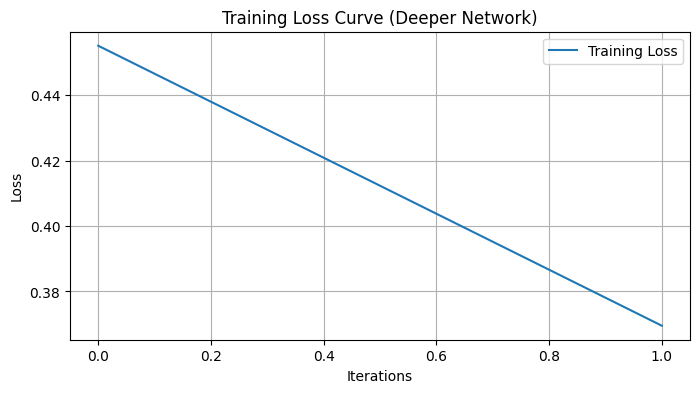

In [13]:
# PLOT 2: Loss Curve
# Verify the model actually learned (curve should go down and flatten)
plt.figure(figsize=(8, 4))
plt.plot(model.loss_curve_, label='Training Loss')
plt.title("Training Loss Curve (Deeper Network)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

5. EVALUATION
* Testing on unseen data.

In [14]:
print("Predicting on Test Set...")
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform to get DEGREES back
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n" + "="*30)
print("MODEL RESULTS")
print("="*30)
print(f"Mean Absolute Error: {mae:.4f} degrees")
print(f"RMSE:                {rmse:.4f} degrees")
print("-" * 30)

Predicting on Test Set...

MODEL RESULTS
Mean Absolute Error: 2.2302 degrees
RMSE:                2.7678 degrees
------------------------------


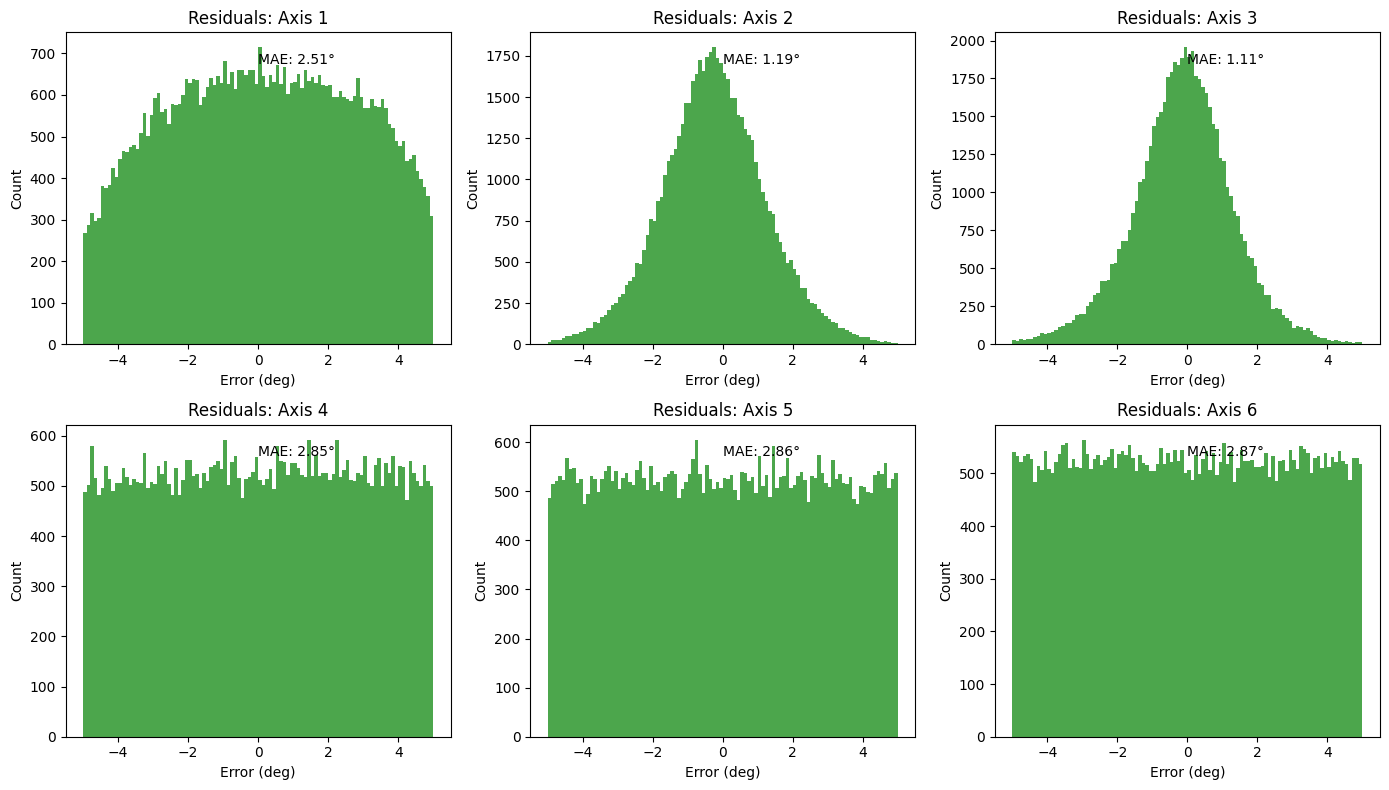

In [15]:
# PLOT 3: Residuals (Errors) per Axis Histogram
# Shows us the 'tail' risks. We want a sharp peak at 0.
errors = y_test - y_pred
axis_names = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6']

plt.figure(figsize=(14, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # Filter large outliers for clearer visualization of the core distribution
    # We focus on +/- 5 degrees to see the bell curve
    data_to_plot = errors[:, i]
    plt.hist(data_to_plot, bins=100, range=(-5, 5), color='green', alpha=0.7)
    plt.title(f"Residuals: Axis {i+1}")
    plt.xlabel("Error (deg)")
    plt.ylabel("Count")
    
    # Add statistics to the plot
    axis_mae = np.mean(np.abs(data_to_plot))
    plt.text(0.5, 0.9, f"MAE: {axis_mae:.2f}°", transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

The tails on q1-q3 are expected due to the kinematic chain's leverage. The model provides a solid "coarse" guess, but it proves that ML alone is insufficient for high precision, validating the need for our secondary numerical correction step.

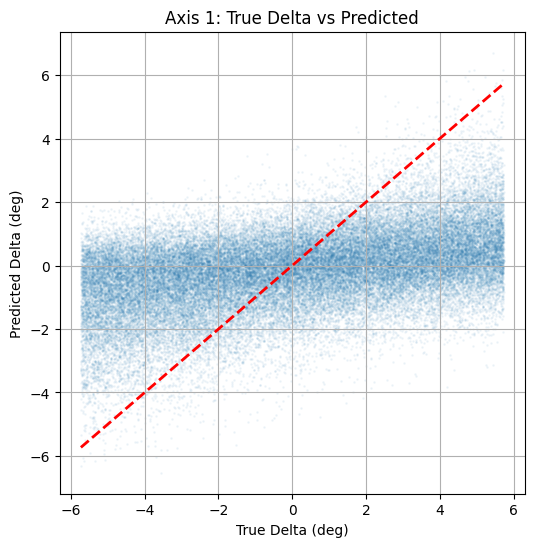

In [16]:
# PLOT 4: Scatter Plot (True vs Predicted)
# Perfect predictions would lie exactly on the red diagonal line.

plt.figure(figsize=(6, 6))
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.05, s=1) # Axis 1 only
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Axis 1: True Delta vs Predicted")
plt.xlabel("True Delta (deg)")
plt.ylabel("Predicted Delta (deg)")
plt.grid(True)
plt.show()

6. SAVE ARTIFACTS
* We need these for the Hybrid Loop later.

In [17]:
print("Saving model and scalers...")
joblib.dump(model, os.path.join(MODEL_DIR, "mlp_baseline.pkl"))
joblib.dump(scaler_x, os.path.join(MODEL_DIR, "scaler_x.pkl"))
joblib.dump(scaler_y, os.path.join(MODEL_DIR, "scaler_y.pkl"))

print(f"Saved to: {MODEL_DIR}")
print("Phase 2 Complete.")

Saving model and scalers...
Saved to: C:\Users\ayber\OneDrive\Masaüstü\ML\Models
Phase 2 Complete.
